In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading in csv
df = pd.read_csv('crime.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499924 entries, 0 to 499923
Data columns (total 19 columns):
INCIDENT_ID               499924 non-null int64
OFFENSE_ID                499924 non-null int64
OFFENSE_CODE              499924 non-null int64
OFFENSE_CODE_EXTENSION    499924 non-null int64
OFFENSE_TYPE_ID           499924 non-null object
OFFENSE_CATEGORY_ID       499924 non-null object
FIRST_OCCURRENCE_DATE     499924 non-null object
LAST_OCCURRENCE_DATE      158159 non-null object
REPORTED_DATE             499924 non-null object
INCIDENT_ADDRESS          450974 non-null object
GEO_X                     495804 non-null float64
GEO_Y                     495804 non-null float64
GEO_LON                   495804 non-null float64
GEO_LAT                   495804 non-null float64
DISTRICT_ID               499924 non-null int64
PRECINCT_ID               499924 non-null int64
NEIGHBORHOOD_ID           499924 non-null object
IS_CRIME                  499924 non-null int64
IS_TRAFFIC

In [4]:
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [5]:
#converting potential index of reported crime date to datetime pandas
df['REPORTED_DATE']= pd.to_datetime(df['REPORTED_DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499924 entries, 0 to 499923
Data columns (total 19 columns):
INCIDENT_ID               499924 non-null int64
OFFENSE_ID                499924 non-null int64
OFFENSE_CODE              499924 non-null int64
OFFENSE_CODE_EXTENSION    499924 non-null int64
OFFENSE_TYPE_ID           499924 non-null object
OFFENSE_CATEGORY_ID       499924 non-null object
FIRST_OCCURRENCE_DATE     499924 non-null object
LAST_OCCURRENCE_DATE      158159 non-null object
REPORTED_DATE             499924 non-null datetime64[ns]
INCIDENT_ADDRESS          450974 non-null object
GEO_X                     495804 non-null float64
GEO_Y                     495804 non-null float64
GEO_LON                   495804 non-null float64
GEO_LAT                   495804 non-null float64
DISTRICT_ID               499924 non-null int64
PRECINCT_ID               499924 non-null int64
NEIGHBORHOOD_ID           499924 non-null object
IS_CRIME                  499924 non-null int64
IS

In [6]:
#comparison of crime vs traffic
print(df.IS_CRIME.value_counts())
print(df.IS_TRAFFIC.value_counts())

1    369905
0    130019
Name: IS_CRIME, dtype: int64
0    369638
1    130286
Name: IS_TRAFFIC, dtype: int64


In [7]:
#dropping traffic to focus on crimes, disregarding traffic crimes
df = df[df.IS_TRAFFIC == 0]
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,2018-01-29 17:53:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,2016-04-26 21:02:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,2018-01-30 22:29:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,2017-06-23 16:09:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [8]:
#crimes by category
df.OFFENSE_CATEGORY_ID.value_counts()

all-other-crimes                90597
public-disorder                 52097
larceny                         50619
theft-from-motor-vehicle        37608
drug-alcohol                    32990
auto-theft                      26629
burglary                        24593
other-crimes-against-persons    24539
aggravated-assault              11735
white-collar-crime               6759
robbery                          6453
sexual-assault                   4123
arson                             626
murder                            270
Name: OFFENSE_CATEGORY_ID, dtype: int64

In [9]:
#dropping many columns to focus on drug/alcohol crimes
df = df.drop(['OFFENSE_ID', 'OFFENSE_CODE', "OFFENSE_CODE_EXTENSION", "OFFENSE_TYPE_ID", "FIRST_OCCURRENCE_DATE", "LAST_OCCURRENCE_DATE", "IS_TRAFFIC", "IS_CRIME", 'INCIDENT_ID', 'DISTRICT_ID', 'PRECINCT_ID'], axis=1)

df.head()

,OFFENSE_CATEGORY_ID,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID
0,all-other-crimes,2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,montbello
1,larceny,2018-01-29 17:53:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,gateway-green-valley-ranch
2,theft-from-motor-vehicle,2016-04-26 21:02:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,wellshire
3,larceny,2018-01-30 22:29:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,belcaro
4,larceny,2017-06-23 16:09:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,cherry-creek


In [10]:
#casting category id as category and then dummies
df["OFFENSE_CATEGORY_ID"] = df["OFFENSE_CATEGORY_ID"].astype('category')
df.dtypes

OFFENSE_CATEGORY_ID          category
REPORTED_DATE          datetime64[ns]
INCIDENT_ADDRESS               object
GEO_X                         float64
GEO_Y                         float64
GEO_LON                       float64
GEO_LAT                       float64
NEIGHBORHOOD_ID                object
dtype: object

In [11]:
#dfdummies dataframe of dummies for categorical variables
df = pd.get_dummies(df, columns=["OFFENSE_CATEGORY_ID"])

df.head()

,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_aggravated-assault,OFFENSE_CATEGORY_ID_all-other-crimes,OFFENSE_CATEGORY_ID_arson,...,OFFENSE_CATEGORY_ID_burglary,OFFENSE_CATEGORY_ID_drug-alcohol,OFFENSE_CATEGORY_ID_larceny,OFFENSE_CATEGORY_ID_murder,OFFENSE_CATEGORY_ID_other-crimes-against-persons,OFFENSE_CATEGORY_ID_public-disorder,OFFENSE_CATEGORY_ID_robbery,OFFENSE_CATEGORY_ID_sexual-assault,OFFENSE_CATEGORY_ID_theft-from-motor-vehicle,OFFENSE_CATEGORY_ID_white-collar-crime
0,2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,montbello,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-29 17:53:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,gateway-green-valley-ranch,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2016-04-26 21:02:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,wellshire,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2018-01-30 22:29:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,belcaro,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2017-06-23 16:09:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,cherry-creek,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369638 entries, 0 to 499923
Data columns (total 21 columns):
REPORTED_DATE                                       369638 non-null datetime64[ns]
INCIDENT_ADDRESS                                    336140 non-null object
GEO_X                                               365518 non-null float64
GEO_Y                                               365518 non-null float64
GEO_LON                                             365518 non-null float64
GEO_LAT                                             365518 non-null float64
NEIGHBORHOOD_ID                                     369638 non-null object
OFFENSE_CATEGORY_ID_aggravated-assault              369638 non-null uint8
OFFENSE_CATEGORY_ID_all-other-crimes                369638 non-null uint8
OFFENSE_CATEGORY_ID_arson                           369638 non-null uint8
OFFENSE_CATEGORY_ID_auto-theft                      369638 non-null uint8
OFFENSE_CATEGORY_ID_burglary                        3696

In [13]:
#resetting date index to datetime index
df = df.set_index('REPORTED_DATE')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369638 entries, 2016-06-15 23:31:00 to 2018-12-12 16:42:00
Data columns (total 20 columns):
INCIDENT_ADDRESS                                    336140 non-null object
GEO_X                                               365518 non-null float64
GEO_Y                                               365518 non-null float64
GEO_LON                                             365518 non-null float64
GEO_LAT                                             365518 non-null float64
NEIGHBORHOOD_ID                                     369638 non-null object
OFFENSE_CATEGORY_ID_aggravated-assault              369638 non-null uint8
OFFENSE_CATEGORY_ID_all-other-crimes                369638 non-null uint8
OFFENSE_CATEGORY_ID_arson                           369638 non-null uint8
OFFENSE_CATEGORY_ID_auto-theft                      369638 non-null uint8
OFFENSE_CATEGORY_ID_burglary                        369638 non-null uint8
OFFENSE_CATEGORY_ID_drug-alcoho

In [14]:
df.head()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_aggravated-assault,OFFENSE_CATEGORY_ID_all-other-crimes,OFFENSE_CATEGORY_ID_arson,OFFENSE_CATEGORY_ID_auto-theft,OFFENSE_CATEGORY_ID_burglary,OFFENSE_CATEGORY_ID_drug-alcohol,OFFENSE_CATEGORY_ID_larceny,OFFENSE_CATEGORY_ID_murder,OFFENSE_CATEGORY_ID_other-crimes-against-persons,OFFENSE_CATEGORY_ID_public-disorder,OFFENSE_CATEGORY_ID_robbery,OFFENSE_CATEGORY_ID_sexual-assault,OFFENSE_CATEGORY_ID_theft-from-motor-vehicle,OFFENSE_CATEGORY_ID_white-collar-crime
REPORTED_DATE,,,,,,,,,,,,,,,,,,,,
2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,montbello,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-29 17:53:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,gateway-green-valley-ranch,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-04-26 21:02:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,wellshire,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-01-30 22:29:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,belcaro,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-06-23 16:09:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,cherry-creek,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [15]:
#df.index = df.index.sort_values()
df = df.sort_index()
df.head()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_aggravated-assault,OFFENSE_CATEGORY_ID_all-other-crimes,OFFENSE_CATEGORY_ID_arson,OFFENSE_CATEGORY_ID_auto-theft,OFFENSE_CATEGORY_ID_burglary,OFFENSE_CATEGORY_ID_drug-alcohol,OFFENSE_CATEGORY_ID_larceny,OFFENSE_CATEGORY_ID_murder,OFFENSE_CATEGORY_ID_other-crimes-against-persons,OFFENSE_CATEGORY_ID_public-disorder,OFFENSE_CATEGORY_ID_robbery,OFFENSE_CATEGORY_ID_sexual-assault,OFFENSE_CATEGORY_ID_theft-from-motor-vehicle,OFFENSE_CATEGORY_ID_white-collar-crime
REPORTED_DATE,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:36:00,NaN,3133650.0,1681488.0,-105.024998,39.703526,athmar-park,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-02 00:36:00,NaN,3133650.0,1681488.0,-105.024998,39.703526,athmar-park,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-02 01:06:00,650 15TH ST,3142454.0,1696151.0,-104.993418,39.743649,cbd,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2014-01-02 01:06:00,650 15TH ST,3142454.0,1696151.0,-104.993418,39.743649,cbd,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2014-01-02 01:25:00,1500 BLOCK N WASHINGTON ST,3146612.0,1695152.0,-104.978652,39.740842,north-capitol-hill,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df.tail()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_aggravated-assault,OFFENSE_CATEGORY_ID_all-other-crimes,OFFENSE_CATEGORY_ID_arson,OFFENSE_CATEGORY_ID_auto-theft,OFFENSE_CATEGORY_ID_burglary,OFFENSE_CATEGORY_ID_drug-alcohol,OFFENSE_CATEGORY_ID_larceny,OFFENSE_CATEGORY_ID_murder,OFFENSE_CATEGORY_ID_other-crimes-against-persons,OFFENSE_CATEGORY_ID_public-disorder,OFFENSE_CATEGORY_ID_robbery,OFFENSE_CATEGORY_ID_sexual-assault,OFFENSE_CATEGORY_ID_theft-from-motor-vehicle,OFFENSE_CATEGORY_ID_white-collar-crime
REPORTED_DATE,,,,,,,,,,,,,,,,,,,,
2019-07-26 03:56:00,555 17TH ST,3143646.0,1696724.0,-104.989167,39.745203,cbd,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2019-07-26 03:58:00,1277 N MEADE ST,3130537.0,1693397.0,-105.035845,39.736263,west-colfax,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-07-26 03:58:00,1277 N MEADE ST,3130537.0,1693397.0,-105.035845,39.736263,west-colfax,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2019-07-26 04:05:00,663 S MEADE ST,3130450.0,1681975.0,-105.036362,39.704909,westwood,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-07-26 04:05:00,663 S MEADE ST,3130450.0,1681975.0,-105.036362,39.704909,westwood,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
#2019's incomplete data gets dropped here

df = df[(df.index.year != 2019)]

df.tail()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_aggravated-assault,OFFENSE_CATEGORY_ID_all-other-crimes,OFFENSE_CATEGORY_ID_arson,OFFENSE_CATEGORY_ID_auto-theft,OFFENSE_CATEGORY_ID_burglary,OFFENSE_CATEGORY_ID_drug-alcohol,OFFENSE_CATEGORY_ID_larceny,OFFENSE_CATEGORY_ID_murder,OFFENSE_CATEGORY_ID_other-crimes-against-persons,OFFENSE_CATEGORY_ID_public-disorder,OFFENSE_CATEGORY_ID_robbery,OFFENSE_CATEGORY_ID_sexual-assault,OFFENSE_CATEGORY_ID_theft-from-motor-vehicle,OFFENSE_CATEGORY_ID_white-collar-crime
REPORTED_DATE,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:03:00,2075 N BROADWAY ST,3144077.0,1698621.0,-104.987597,39.750404,five-points,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:35:00,3900 BLOCK N TENNYSON ST,3128265.0,1706076.0,-105.043697,39.771101,berkeley,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-12-31 23:35:00,3900 BLOCK N TENNYSON ST,3128265.0,1706076.0,-105.043697,39.771101,berkeley,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-12-31 23:36:00,990 N LOGAN ST,3145715.0,1691811.0,-104.981910,39.731684,capitol-hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-31 23:56:00,E 16TH AVE / N VALENTIA ST,3171066.0,1695718.0,-104.891683,39.741978,east-colfax,0,0,1,0,0,0,0,0,0,0,0,0,0,0


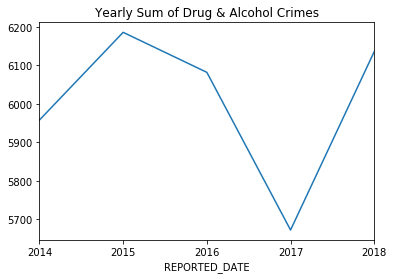

In [18]:
df['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('A').sum().plot(title='Yearly Sum of Drug & Alcohol Crimes');

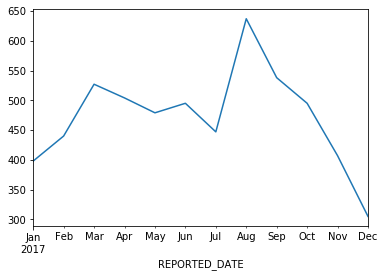

In [19]:
#What's up with that drop in 2017? 
df2017 = df[(df.index.year == 2017)]

df2017['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('M').sum().plot()

In [20]:
#Looks to be concentrated around June!

In [21]:
#some stats of drug/alc crimes through 2018 as series of annual data
annual_da = df['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('A').sum()

annual_da.describe()

count       5.000000
mean     6006.800000
std       205.507177
min      5672.000000
25%      5958.000000
50%      6082.000000
75%      6136.000000
max      6186.000000
Name: OFFENSE_CATEGORY_ID_drug-alcohol, dtype: float64

In [22]:
#2017 is less than 2 std from the mean, meaning interesting data, but not an outlier

In [23]:
df_drug_al = df[(df['OFFENSE_CATEGORY_ID_drug-alcohol'] == 1)]

df_drug_al = df_drug_al.drop(['OFFENSE_CATEGORY_ID_aggravated-assault', 'OFFENSE_CATEGORY_ID_all-other-crimes','OFFENSE_CATEGORY_ID_arson', 'OFFENSE_CATEGORY_ID_auto-theft', 'OFFENSE_CATEGORY_ID_burglary', 'OFFENSE_CATEGORY_ID_larceny', 'OFFENSE_CATEGORY_ID_murder', 'OFFENSE_CATEGORY_ID_other-crimes-against-persons','OFFENSE_CATEGORY_ID_public-disorder', 'OFFENSE_CATEGORY_ID_robbery', 'OFFENSE_CATEGORY_ID_sexual-assault','OFFENSE_CATEGORY_ID_theft-from-motor-vehicle', 'OFFENSE_CATEGORY_ID_white-collar-crime'], axis=1)

df_drug_al.head()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_drug-alcohol
REPORTED_DATE,,,,,,,
2014-01-02 12:00:00,24TH ST / LAWRENCE ST,3144264.0,1700664.0,-104.986891,39.756010,five-points,1
2014-01-02 15:26:00,1331 N SPEER BLVD,3141191.0,1693918.0,-104.997953,39.737538,lincoln-park,1
2014-01-02 15:43:00,N SPEER BLVD / CHAMPA ST,3140792.0,1695655.0,-104.999338,39.742312,cbd,1
2014-01-02 15:55:00,E COLFAX AVE / N DOWNING ST,3148176.0,1694866.0,-104.973097,39.740032,capitol-hill,1
2014-01-02 16:29:00,1300 BLOCK N VINE ST,3151256.0,1694000.0,-104.962163,39.737605,cheesman-park,1


In [24]:
#Most occurring neighborhoods 
df_drug_al.NEIGHBORHOOD_ID.value_counts()

five-points                  3723
capitol-hill                 2641
east-colfax                  2166
cbd                          1977
civic-center                 1290
north-capitol-hill           1212
cheesman-park                1183
lincoln-park                 1029
city-park-west                781
west-colfax                   696
stapleton                     638
westwood                      598
montbello                     593
baker                         547
union-station                 478
athmar-park                   463
villa-park                    410
cole                          374
globeville                    343
mar-lee                       321
sun-valley                    303
college-view-south-platte     291
highland                      276
auraria                       275
ruby-hill                     268
barnum                        267
northeast-park-hill           260
sunnyside                     256
barnum-west                   247
speer         

In [25]:
df_drug_al.NEIGHBORHOOD_ID.value_counts().describe()

count      78.000000
mean      385.051282
std       609.233687
min         4.000000
25%       108.500000
50%       195.000000
75%       316.500000
max      3723.000000
Name: NEIGHBORHOOD_ID, dtype: float64

In [26]:
#Five points is a huge outlier, though there are many neighborhoods to skew the data potentially
len(df_drug_al.NEIGHBORHOOD_ID.value_counts())

78

In [27]:
print(statistics.median(df_drug_al.NEIGHBORHOOD_ID.value_counts()))

195.0


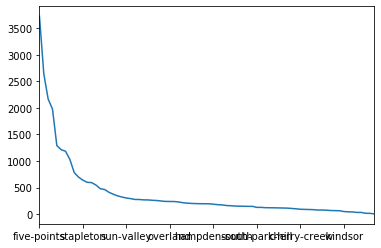

In [28]:
df_drug_al.NEIGHBORHOOD_ID.value_counts().plot()

In [29]:
#focusing on five points as the most crime heavy area
df_fp =df_drug_al[(df_drug_al["NEIGHBORHOOD_ID"] == 'five-points')] 

df_fp.head()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,OFFENSE_CATEGORY_ID_drug-alcohol
REPORTED_DATE,,,,,,,
2014-01-02 12:00:00,24TH ST / LAWRENCE ST,3144264.0,1700664.0,-104.986891,39.756010,five-points,1
2014-01-03 14:16:00,E 22ND AVE / N WASHINGTON ST,3146740.0,1698300.0,-104.978133,39.749481,five-points,1
2014-01-04 04:08:00,2200 BLOCK LARIMER ST,3143421.0,1700233.0,-104.989897,39.754840,five-points,1
2014-01-04 04:27:00,22ND ST / LARIMER ST,3143343.0,1700221.0,-104.990175,39.754808,five-points,1
2014-01-04 11:32:00,1200 BLK 22ND ST,3143548.0,1699986.0,-104.989451,39.754160,five-points,1


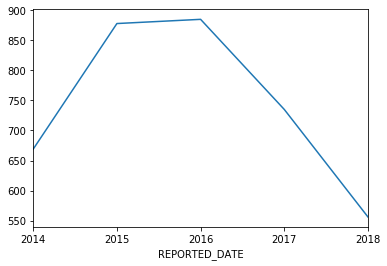

In [30]:
df_fp['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('A').sum().plot()

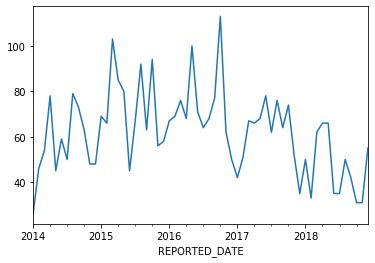

In [31]:
df_fp['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('M').sum().plot()

In [32]:
# df_fp['6-month-SMA'] =  df_fp['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('A').sum().rolling(window=6).mean()
# df_fp['12-month-SMA'] =  df_fp['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('A').sum().rolling(window=12).mean()

In [33]:
#conversion to weeks
df_fp2 = df_fp
df_fp2 = df_fp['OFFENSE_CATEGORY_ID_drug-alcohol'].resample('W', how='sum')
df_fp2

REPORTED_DATE
2014-01-05     5
2014-01-12     6
2014-01-19     8
2014-01-26     5
2014-02-02     2
2014-02-09     4
2014-02-16    14
2014-02-23     8
2014-03-02    22
2014-03-09     8
2014-03-16    15
2014-03-23    15
2014-03-30    12
2014-04-06    13
2014-04-13    25
2014-04-20    21
2014-04-27    11
2014-05-04    12
2014-05-11     7
2014-05-18    12
2014-05-25    11
2014-06-01    14
2014-06-08    16
2014-06-15    12
2014-06-22    12
2014-06-29    13
2014-07-06    15
2014-07-13    10
2014-07-20    11
2014-07-27    11
              ..
2018-06-10     9
2018-06-17    10
2018-06-24     7
2018-07-01     9
2018-07-08    12
2018-07-15    10
2018-07-22     5
2018-07-29     4
2018-08-05     7
2018-08-12     4
2018-08-19    11
2018-08-26    16
2018-09-02    18
2018-09-09    10
2018-09-16    14
2018-09-23    10
2018-09-30     5
2018-10-07     8
2018-10-14     9
2018-10-21     9
2018-10-28     3
2018-11-04     4
2018-11-11     4
2018-11-18     3
2018-11-25     8
2018-12-02    14
2018-12-09    20


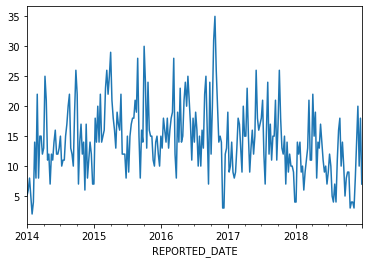

In [34]:
df_fp2.plot()

In [35]:
len(df_fp2)

261

In [36]:
df_fp2 = df_fp2.to_frame() 

df_fp2.head()

,OFFENSE_CATEGORY_ID_drug-alcohol
REPORTED_DATE,
2014-01-05,5
2014-01-12,6
2014-01-19,8
2014-01-26,5
2014-02-02,2


In [37]:
df_fp2.tail()

,OFFENSE_CATEGORY_ID_drug-alcohol
REPORTED_DATE,
2018-12-02,14
2018-12-09,20
2018-12-16,10
2018-12-23,18
2018-12-30,7


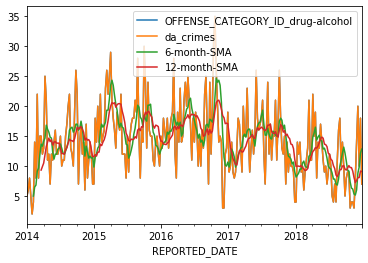

In [38]:
df_fp2['da_crimes'] = df_fp2['OFFENSE_CATEGORY_ID_drug-alcohol']

df_fp2['6-month-SMA'] = df_fp2['da_crimes'].rolling(window=6).mean()
df_fp2['12-month-SMA'] = df_fp2['da_crimes'].rolling(window=12).mean()
df_fp2.plot()

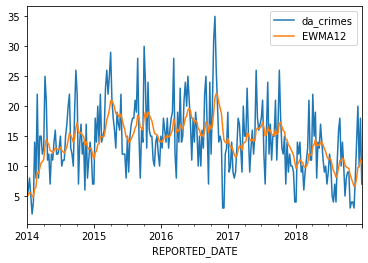

In [39]:
df_fp2['EWMA12'] = df_fp2['da_crimes'].ewm(span=12,adjust=False).mean()

df_fp2[['da_crimes','EWMA12']].plot();

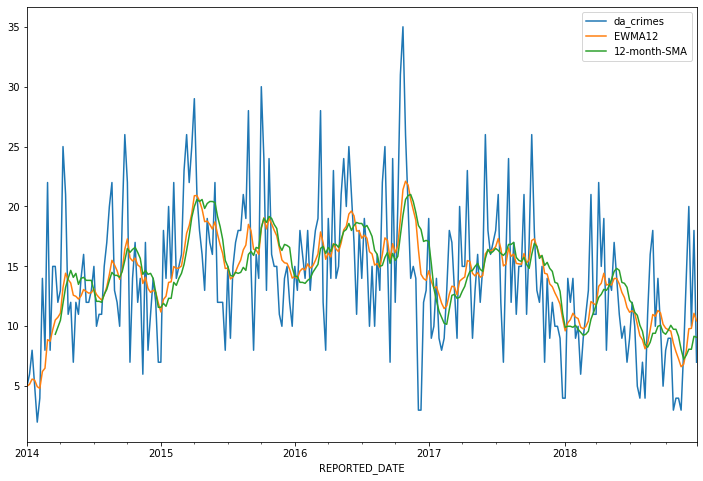

In [40]:
df_fp2[['da_crimes','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

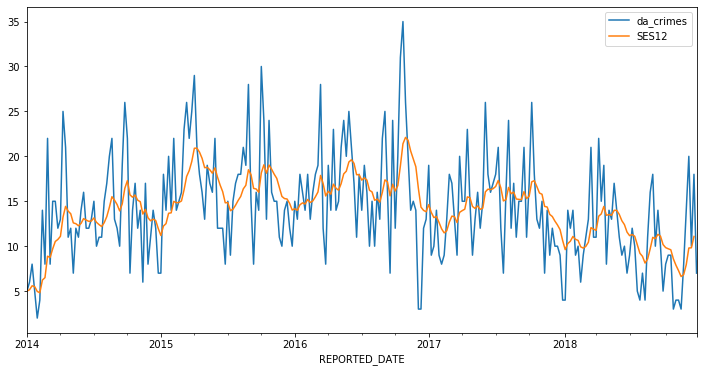

In [41]:
span = 12
alpha = 2/(span+1)

df_fp2['SES12']=SimpleExpSmoothing(df_fp2['da_crimes']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df_fp2[['da_crimes','SES12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [42]:
#195 is 75% for a training set for forecasting of fp_points 
df_fp2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2014-01-05 to 2018-12-30
Freq: W-SUN
Data columns (total 6 columns):
OFFENSE_CATEGORY_ID_drug-alcohol    261 non-null uint8
da_crimes                           261 non-null uint8
6-month-SMA                         256 non-null float64
12-month-SMA                        250 non-null float64
EWMA12                              261 non-null float64
SES12                               260 non-null float64
dtypes: float64(4), uint8(2)
memory usage: 10.7 KB


In [43]:
fp_train_data = df_fp2.iloc[:196] # Goes up to but not including 195
fp_test_data = df_fp2.iloc[196:]

In [44]:
fp_train = fp_train_data.drop(['6-month-SMA', '12-month-SMA', 'EWMA12', 'SES12'], axis=1)

fp_train

,OFFENSE_CATEGORY_ID_drug-alcohol,da_crimes
REPORTED_DATE,,
2014-01-05,5,5
2014-01-12,6,6
2014-01-19,8,8
2014-01-26,5,5
2014-02-02,2,2
2014-02-09,4,4
2014-02-16,14,14
2014-02-23,8,8
2014-03-02,22,22


In [45]:
#first order differencing towards stationary data
# Calculate the first difference of the non-stationary data
df_fp2['sdiff'] = df_fp2['da_crimes'] - df_fp2['da_crimes'].shift(1)

df_fp2[['da_crimes','sdiff']].head() 

,da_crimes,sdiff
REPORTED_DATE,,
2014-01-05,5,NaN
2014-01-12,6,1.0
2014-01-19,8,2.0
2014-01-26,5,-3.0
2014-02-02,2,-3.0


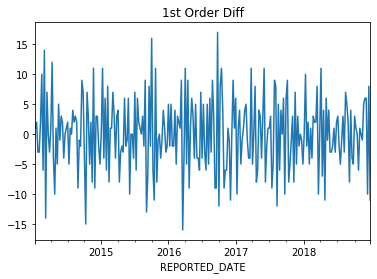

In [46]:
df_fp2['sdiff'].plot(title="1st Order Diff").autoscale(axis='x',tight=True);

In [47]:
#extending date_range 5 months into the future
idx = pd.date_range('2019-01-01', periods=5, freq='M')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
2019-01-31,7
2019-02-28,-2
2019-03-31,5
2019-04-30,-1
2019-05-31,12


In [48]:
#backwards cumulative building of forecast
z['forecast']=df_fp2['da_crimes'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,forecast
2019-01-31,7,14
2019-02-28,-2,12
2019-03-31,5,17
2019-04-30,-1,16
2019-05-31,12,28


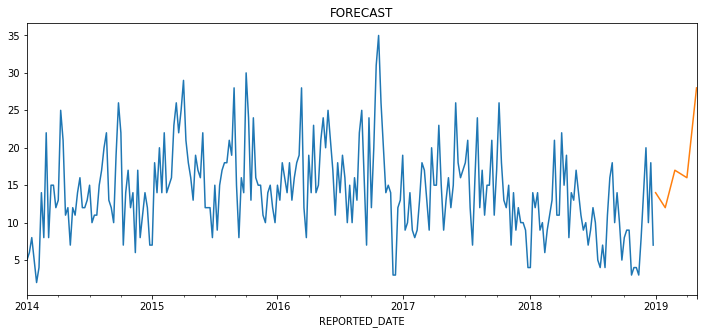

In [49]:
df_fp2['da_crimes'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

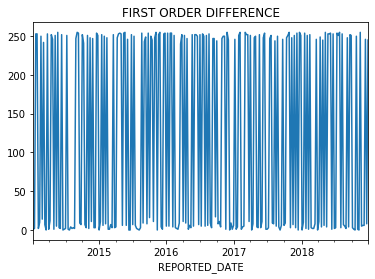

In [50]:
# first order difference of dataset
df_fp2['fod'] = df_fp2['da_crimes'].diff()

df_fp2['fod'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [51]:
# second order difference 
df_fp2['sod'] = df_fp2['da_crimes'].diff().diff()

df_fp2[['da_crimes','fod','sod']].head()

,da_crimes,fod,sod
REPORTED_DATE,,,
2014-01-05,5,NaN,NaN
2014-01-12,6,1.0,NaN
2014-01-19,8,2.0,1.0
2014-01-26,5,253.0,251.0
2014-02-02,2,253.0,0.0


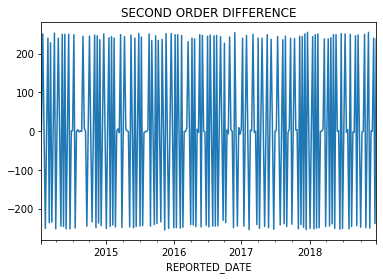

In [52]:
df_fp2['sod'].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [53]:
# second order build a forecast series 
idx = pd.date_range('2019-01-01', periods=5, freq='M')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
2019-01-31,7
2019-02-28,-2
2019-03-31,5
2019-04-30,-1
2019-05-31,12


In [54]:
# add most recent fod from training set to Fcast cumsum
z['firstdiff'] = (df_fp2['da_crimes'].iloc[-1]-df_fp2['da_crimes'].iloc[-2]) + z['Fcast'].cumsum()

# build forecast values fromfod set
z['forecast'] = df_fp2['da_crimes'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
2019-01-31,7,252,259
2019-02-28,-2,250,509
2019-03-31,5,255,764
2019-04-30,-1,254,1018
2019-05-31,12,266,1284


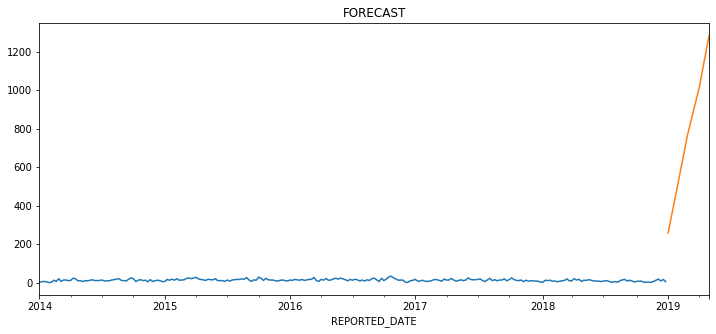

In [55]:
df_fp2['da_crimes'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

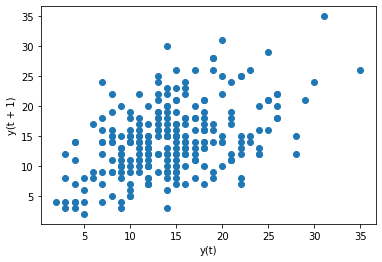

In [56]:
from pandas.plotting import lag_plot

lag_plot(df_fp2['da_crimes']) #mild autocorrelation from plot 

In [57]:
fp_points = df_fp2

acf(fp_points['da_crimes'])

array([ 1.00000000e+00,  4.61785628e-01,  3.18037798e-01,  2.33028855e-01,
        1.84982424e-01,  1.78169809e-01,  1.44096757e-01,  1.31207348e-01,
        1.43047570e-01,  1.07696766e-01,  8.11651251e-03,  7.53667517e-03,
       -1.86007975e-02, -7.53972309e-04, -3.38560371e-02,  6.49117806e-03,
        4.77430882e-02,  6.87862426e-02,  8.86283364e-02,  7.71622618e-02,
        9.84913830e-02,  7.38942317e-02,  1.35761750e-01,  1.96016156e-01,
        1.82448226e-01,  1.58173437e-01,  7.13382052e-02,  1.05362954e-01,
        9.45091082e-02,  6.30799494e-02,  2.78890269e-02,  1.30391132e-01,
        1.69714066e-01,  1.35596819e-01,  7.55766699e-03, -1.14787294e-02,
        2.50274313e-02, -3.12678430e-02, -4.30835770e-02,  2.53585791e-02,
        6.58721749e-02])

In [58]:
fp_points.head()

,OFFENSE_CATEGORY_ID_drug-alcohol,da_crimes,6-month-SMA,12-month-SMA,EWMA12,SES12,sdiff,fod,sod
REPORTED_DATE,,,,,,,,,
2014-01-05,5,5,NaN,NaN,5.000000,5.000000,NaN,NaN,NaN
2014-01-12,6,6,NaN,NaN,5.153846,5.153846,1.0,1.0,NaN
2014-01-19,8,8,NaN,NaN,5.591716,5.591716,2.0,2.0,1.0
2014-01-26,5,5,NaN,NaN,5.500683,5.500683,-3.0,253.0,251.0
2014-02-02,2,2,NaN,NaN,4.962116,4.962116,-3.0,253.0,0.0


In [59]:
fp_points = fp_points.drop(['sdiff', 'fod', 'sod', '6-month-SMA', '12-month-SMA', 'EWMA12', 'SES12', 'OFFENSE_CATEGORY_ID_drug-alcohol'], axis=1)
fp_points.head()

,da_crimes
REPORTED_DATE,
2014-01-05,5
2014-01-12,6
2014-01-19,8
2014-01-26,5
2014-02-02,2


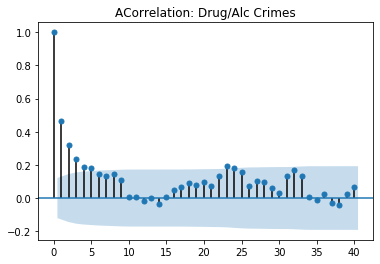

In [60]:
title = 'ACorrelation: Drug/Alc Crimes'
lags = 40
plot_acf(fp_points,title=title,lags=lags);

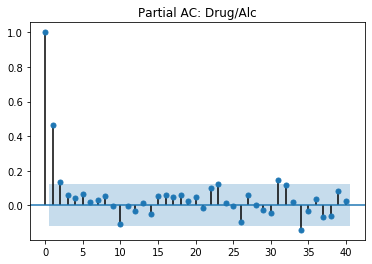

In [61]:
#partial auto correlate
title='Partial AC: Drug/Alc'
lags=40
plot_pacf(fp_points,title=title,lags=lags);

In [62]:
#define function for ADFuller test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(fp_points['da_crimes'])


Results of Dickey-Fuller Test:
Test Statistic                   7.884090
p-value                          1.000000
#Lags Used                       0.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


Lambda: 0.636133


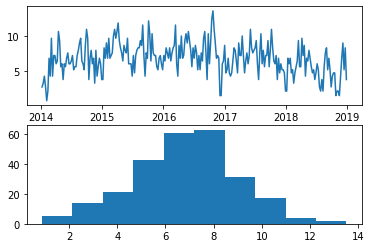

In [63]:
#now with box cox transform
fp_points['da_crimes'], lam = boxcox(fp_points['da_crimes'])
print('Lambda: %f' % lam)
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(fp_points['da_crimes'])
# histogram
plt.subplot(212)
plt.hist(fp_points['da_crimes'])
plt.show()

(array([ 5., 14., 21., 43., 61., 63., 31., 17.,  4.,  2.]),
 array([ 0.87113515,  2.13580618,  3.40047721,  4.66514824,  5.92981927,
         7.1944903 ,  8.45916133,  9.72383236, 10.98850339, 12.25317442,
        13.51784545]),
 <a list of 10 Patch objects>)

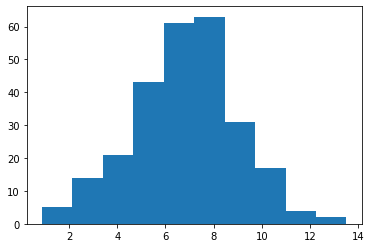

In [64]:
plt.hist(fp_points['da_crimes'])

In [65]:
# ETS plot towards stationary
fp_s_result = seasonal_decompose(fp_points['da_crimes'], model='multiplicative') 

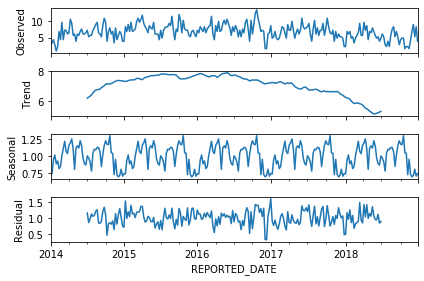

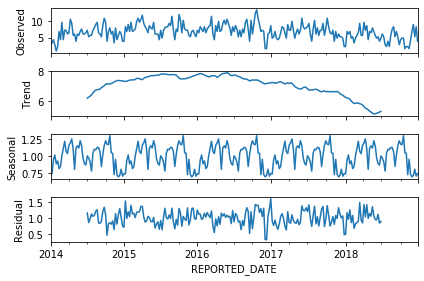

In [66]:
fp_s_result.plot()

In [67]:
#test stat less than crit value!
adf_test(fp_points['da_crimes'])

Results of Dickey-Fuller Test:
Test Statistic                -7.182507e+00
p-value                        2.627530e-10
#Lags Used                     1.000000e+00
Number of Observations Used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


In [68]:
fp_points = fp_points.drop(['diff1'], axis=1)

auto_arima(fp_points['da_crimes'],error_action='ignore', seasonal=True).summary()

KeyError: "['diff1'] not found in axis"

In [ ]:
len(fp_points)

In [ ]:
# Set 195 data points for testing
train = fp_points.iloc[:196]
test = fp_points.iloc[196:]

train.head()

In [ ]:
sarima_model = SARIMAX(train['da_crimes'],order=(1,1,1))
sarima_results = sarima_model.fit()
sarima_results.summary()

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = sarima_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predict')

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['da_crimes'][i]}")

In [ ]:
# Plot predictions against known values
title = 'Monthly Mean Drug/Alcohol Crimes, Five Points, Denver CO'
ylabel='Crime amount'
xlabel=''

ax = test['da_crimes'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['da_crimes'], predictions)
print(f'SARIMA MSE Error: {error:11.10}')

In [ ]:
# ^ better than 22 or so on the first attempts
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test['da_crimes'], predictions)

In [ ]:
from math import sqrt
mse = mean_squared_error(test['da_crimes'], predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

In [ ]:
#swingy results!
forecast_errors = [test['da_crimes'][i]-predictions[i] for i in range(len(test['da_crimes']))]
print('Forecast Errors: %s' % forecast_errors)

In [ ]:
#SARIMAX on full data
s_full_model = SARIMAX(fp_points['da_crimes'],order=(1,0,0))
s_full_results = s_full_model.fit()
s_fcast = s_full_results.predict(len(fp_points),len(fp_points)+11,typ='levels').rename('SARIMA(1,0,0) Fcast')

In [ ]:
# Plot predictions against known values
title = 'Monthly Full Model'
ylabel='Crime amount'
xlabel=''

ax = fp_points['da_crimes'].plot(legend=True,figsize=(12,6),title=title)
s_fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# Set same amount of group for RNN 
train = fp_points.iloc[:196]
test = fp_points.iloc[196:]

train.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

In [ ]:
# 120 in, 10 week out
n_input = 120
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
# fit model
model.fit_generator(generator,epochs=50)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
first_eval_batch = scaled_train[-120:]

In [ ]:
first_eval_batch

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

current_batch.shape

In [ ]:
current_batch

In [ ]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
scaled_test

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

In [ ]:
test

In [ ]:
test['Predictions'] = true_predictions
test

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
model.save('scnd_ts_rnn.h5')